In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
data_df = pd.read_pickle('cleaned_features.pkl')
y_label = pd.read_pickle('label.pkl')
feature_columns = data_df.columns

In [3]:
# train test splitting
X_train, X_test, y_train, y_test = train_test_split(data_df[feature_columns], y_label, test_size=0.33, random_state=42)

### Grid Search for SGD SVM

In [21]:
sgd_clf = SGDClassifier(loss='hinge',average=True,n_iter = 100,penalty='l2',class_weight='balanced',shuffle=True)

In [22]:
tuned_parameters = [{'alpha': [10,30,100],
                     }]
scores = ['f1']

for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    print 

    clf = GridSearchCV(sgd_clf, tuned_parameters, cv=5,
                       scoring = score,verbose=True)
    clf.fit(X_train, y_train)

    print "Best parameters set found on development set:",clf.best_params_
    print
    print "Grid scores on development set:"
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print "%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)
    print

    print "Detailed classification report:"
    print 
    print "The model is trained on the full development set."
    print "The scores are computed on the full evaluation set."
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print classification_report(y_true, y_pred)
    print


# Tuning hyper-parameters for f1

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 15.0min finished


Best parameters set found on development set: {'alpha': 100}

Grid scores on development set:
0.627 (+/-0.008) for {'alpha': 10}
0.573 (+/-0.210) for {'alpha': 30}
0.659 (+/-0.004) for {'alpha': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.95      0.99      0.97    598528
          1       0.91      0.52      0.66     63808

avg / total       0.95      0.95      0.94    662336




In [ ]:
def SGD_feature_rank(model,rescale = None, topk=10):

    # get feature names
    feature_names = X_train.columns.tolist()
    
    if rescale:
        # get feature score for normalized data
        norm_feature_score = model.best_estimator_.coef_[0]
        # inverse scaling coefficients
        feature_score = np.true_divide(norm_feature_score,scaling.scale_)
        #absolute score
        abs_score = np.absolute(norm_feature_score)
        feature_df = pd.DataFrame({'feature_names':feature_names,
                               'norm_feature_score':norm_feature_score,
                               'feature_score':feature_score,
                               'abs_score':abs_score
                               })
        # get most siginificant features 
        top_features = feature_df.sort_values('abs_score').iloc[-topk:]
    else:
        # get feature average score
        feature_score = model.best_estimator_.coef_[0]
        abs_score = np.absolute(feature_score)
        feature_df = pd.DataFrame({'feature_names':feature_names,
                                   'feature_score':feature_score,
                                   'abs_score':abs_score
                                 })

    # create a dataframe
    
    # get most siginificant features 
    top_features = feature_df.sort_values('abs_score').iloc[-topk:]
    # generate bar plot
    fig,ax=plt.subplots(figsize=(6,6))
    if rescale:
        ax = top_features['norm_feature_score'].plot.barh(title='feature_importances')
        ax.set_xlabel('normalized_feature score')
    else:
        ax = top_features['feature_score'].plot.barh(title='feature_importances')
        ax.set_xlabel('feature score') 
    ax.set_ylabel('features')
    ax.set_yticklabels(top_features['feature_names'])

In [ ]:
SGD_feature_rank(clf.best_estimator_)

In [15]:
def plot_confusion_matrix(ytest,ypredict):
    cm =confusion_matrix(ytest, ypredict)
    row_sums = cm.astype('float').sum(axis=1,keepdims=True)
    RF_cm = cm / row_sums
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(RF_cm,annot=True)
    ax.set(xlabel='Predicted Label',ylabel='True Label')

In [16]:
def plot_binary_ROC(ytest,yprob):
    fpr,tpr,_= roc_curve(ytest,yprob)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve(area = %0.2f)' %roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    

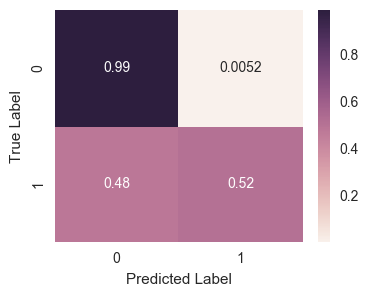

In [23]:
plot_confusion_matrix(y_true,y_pred)
#plot_binary_ROC(y_true,y_prob[:,1])